# Classification Modeling - By Hotel

---

The initial modeling results revealed challenges in accurately classifying reservations, which may stem from significant differences between the two types of hotels in the dataset and from class imbalances in the data. To address these issues, I will train and evaluate separate models for each hotel in this notebook. While this approach is more time and resource-intensive than the combined model—a factor to consider in a production environment—splitting the dataset and developing individual models will help account for the unique characteristics and reservation patterns of each hotel.

Additionally, to tackle the class imbalance inherent in the dataset, I will employ SMOTE with Tomek Links. This technique combines the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic examples of the minority class with Tomek Links to remove overlapping instances from the majority class. By integrating this resampling method into the modeling pipeline, I aim to create a more balanced and cleaner dataset. This combined strategy is expected to enhance classification performance by leveraging hotel-specific insights and effectively addressing the class imbalance.



---

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import shap

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

# Load Data

In [4]:
df_data = pd.read_parquet('../../data/3.2_data_with_occupancies.parquet')
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,342,2015,July,27,1,2,0.0,0,BB,PRT,...,21,45,21,22,44,3,41,41,0.115169,0.115169
56,149,2015,July,27,1,2,1.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
57,149,2015,July,27,1,2,0.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
58,145,2015,July,27,1,2,0.0,0,HB,GBR,...,21,38,28,56,36,3,41,201,0.115169,0.564607
59,110,2015,July,27,1,3,0.0,0,BB,ESP,...,21,40,26,21,71,3,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119362,4,2017,August,35,31,2,0.0,0,SC,FRA,...,16,32,19,39,12,4,271,102,0.761236,0.286517
119366,198,2017,August,35,31,2,0.0,0,SC,GBR,...,16,33,18,59,44,4,271,154,0.761236,0.432584
119372,332,2017,August,35,31,2,0.0,0,BB,GBR,...,16,33,18,2,49,4,271,154,0.761236,0.432584
119380,109,2017,August,35,31,2,0.0,0,BB,GBR,...,16,28,23,27,13,4,271,22,0.761236,0.061798


# Split By Hotel Number

In [5]:
df_data = df_data[df_data['HotelNumber'] == 'H2']
df_data = df_data.reset_index(drop=True)
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,257,2015,July,27,1,1,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
1,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
2,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
3,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
4,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,4,2017,August,35,31,2,0.0,0,SC,FRA,...,16,32,19,39,12,4,271,102,0.761236,0.286517
79326,198,2017,August,35,31,2,0.0,0,SC,GBR,...,16,33,18,59,44,4,271,154,0.761236,0.432584
79327,332,2017,August,35,31,2,0.0,0,BB,GBR,...,16,33,18,2,49,4,271,154,0.761236,0.432584
79328,109,2017,August,35,31,2,0.0,0,BB,GBR,...,16,28,23,27,13,4,271,22,0.761236,0.061798


In [6]:
df_data.columns.to_list()

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'ArrivalDate',
 'DepartureDate',
 'Length of Stay',
 'BookingDate',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'ArrivalDate_DayOfWeek',
 'occupancy_at_arrival',
 'occupancy_at_departure',
 'occupancy_pct_at_arrival',
 'occupancy_pct_at_departure']

In [7]:
selected_features = ['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'ArrivalDate',
 'DepartureDate',
 'Length of Stay',
 'BookingDate',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'ArrivalDate_DayOfWeek',
 'occupancy_at_arrival',
 'occupancy_at_departure',
 'occupancy_pct_at_arrival',
 'occupancy_pct_at_departure']

In [8]:
df_data = df_data[selected_features]
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,257,2015,July,27,1,1,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
1,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
2,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
3,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
4,257,2015,July,27,1,2,0.0,0,HB,PRT,...,21,43,23,52,63,3,41,108,0.115169,0.303371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,4,2017,August,35,31,2,0.0,0,SC,FRA,...,16,32,19,39,12,4,271,102,0.761236,0.286517
79326,198,2017,August,35,31,2,0.0,0,SC,GBR,...,16,33,18,59,44,4,271,154,0.761236,0.432584
79327,332,2017,August,35,31,2,0.0,0,BB,GBR,...,16,33,18,2,49,4,271,154,0.761236,0.432584
79328,109,2017,August,35,31,2,0.0,0,BB,GBR,...,16,28,23,27,13,4,271,22,0.761236,0.061798


# Train/Test Split

In [9]:
target_feature = 'ReservationStatus'

X = df_data.loc[:, selected_features].drop(columns=target_feature)
y = df_data[target_feature].map({'Check-Out': 0, 'Canceled': 1, 'No-Show': 1})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [11]:
y_train.value_counts(normalize=True).round(2)

ReservationStatus
0    0.58
1    0.42
Name: proportion, dtype: float64

In [12]:
y_test.value_counts(normalize=True).round(2)

ReservationStatus
0    0.58
1    0.42
Name: proportion, dtype: float64

# Model: Random Forest Classifer - Baseline

In [13]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              min_frequency=5,
                              max_categories=25))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Build the full pipeline without SMOTE resampling
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced_subsample'))
])

## Model Results

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     46228
           1       0.91      0.83      0.87     33102

    accuracy                           0.89     79330
   macro avg       0.90      0.88      0.89     79330
weighted avg       0.89      0.89      0.89     79330



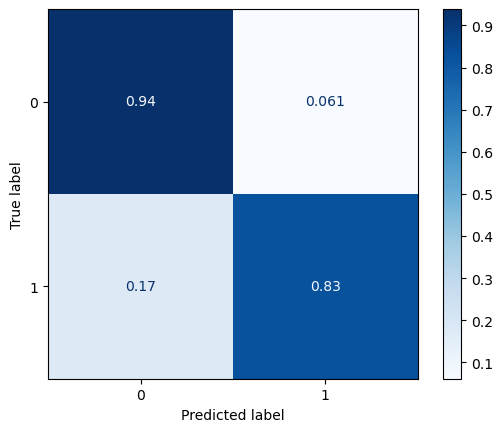

In [14]:
# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

### Tree Depths

In [15]:
# Access the fitted model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['LeadTime', 'ArrivalDateWeekNumber', 'Adults', 'Children', 'Babies',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialReque...
                                                                                 sparse_output=False))]),
                                                  Index(['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth', 'Meal',
       'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
       'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType',
       'HotelNumber'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        random_state=42))])

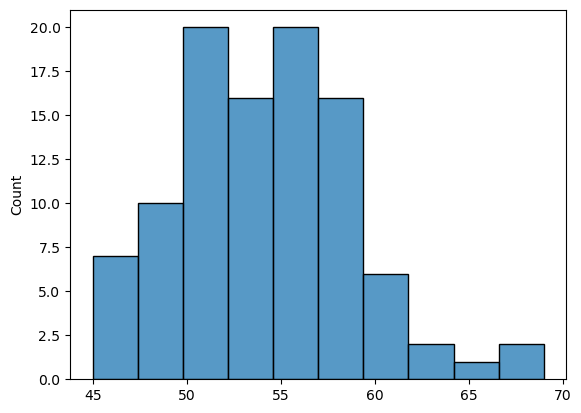

In [16]:
# Get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in model_pipeline[-1].estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# Performing SMOTE to Handle Class Imbalance

---

1. Use preprocessor outside of pipeline to OHE categoricals
2. Check results
3. Create boolean index to identify which columns to treat as categoricals
4. Instantiate a SMOTENC object
5. Reset `set_config` setting to "default" due to compatibility issues
6. Use `.fit_resample` method to perform SMOTENC
7. Reset `set_config` back to "pandas" and convert output data back to DataFrames
8. Confirm OHE'ed categoricals consist only of numeric features again.

---

In [17]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [18]:
X_train_transformed.head()

,num__LeadTime,num__ArrivalDateWeekNumber,num__Adults,num__Children,num__Babies,num__IsRepeatedGuest,num__PreviousCancellations,num__PreviousBookingsNotCanceled,num__BookingChanges,num__DaysInWaitingList,...,cat__Company_ 280,cat__Company_ 348,cat__Company_ 385,cat__Company_ NULL,cat__Company_infrequent_sklearn,cat__CustomerType_Contract,cat__CustomerType_Group,cat__CustomerType_Transient,cat__CustomerType_Transient-Party,cat__HotelNumber_H2
14901,59.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
14920,9.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
71199,108.0,25.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
56598,38.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
21697,101.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [19]:
cat_features = [col.startswith('cat_') for col in X_train_transformed.columns]
cat_features

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 T

In [20]:
## Reset output settings to default for SMOTE
set_config(transform_output='default')

## Perform SMOTE resampling
snc = SMOTENC(categorical_features=cat_features, random_state = 42)
X_train_smote, y_train_smote = snc.fit_resample(X_train_transformed, y_train)

In [21]:
## Reset output settings to pandas
set_config(transform_output='pandas')

X_train_smote = pd.DataFrame(X_train_smote, columns=X_train_transformed.columns)
y_train_smote = pd.Series(y_train_smote)

In [22]:
X_train_smote.nunique()

num__LeadTime                        4867
num__ArrivalDateWeekNumber           1842
num__Adults                          1658
num__Children                         682
num__Babies                            47
                                     ... 
cat__CustomerType_Contract              2
cat__CustomerType_Group                 2
cat__CustomerType_Transient             2
cat__CustomerType_Transient-Party       2
cat__HotelNumber_H2                     1
Length: 182, dtype: int64

# Model: Random Forest Classifier - SMOTENC

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11557
           1       0.89      0.84      0.86      8276

    accuracy                           0.89     19833
   macro avg       0.89      0.88      0.89     19833
weighted avg       0.89      0.89      0.89     19833



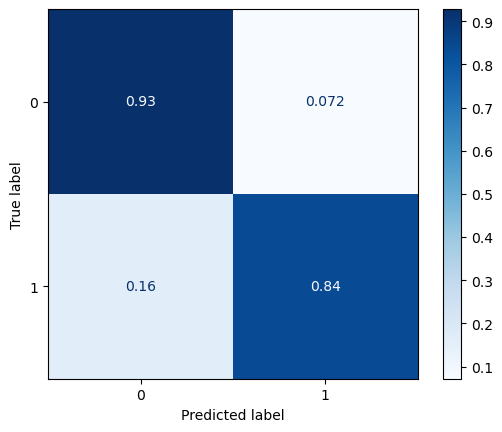

In [23]:
smotenc_model = model_pipeline[-1].fit(X_train_smote, y_train_smote)

y_pred = smotenc_model.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

# SHAP Results Review: Random Forest Classifier

### Non-SMOTE'ed Modeling Approach

In [25]:
# ## Use only if using model pipeline without SMOTENC
# X_train_xf = model_pipeline.named_steps.preprocessor.fit_transform(X_train)
# X_test_xf = model_pipeline.named_steps.preprocessor.transform(X_test)

# X_shap_train = shap.sample(X_train_xf, 500)
# y_shap_train = y_train.loc[X_shap_train.index]

# X_shap_test = shap.sample(X_test_xf, 500)
# y_shap_test = y_test.loc[X_shap_test.index]

# explainer = shap.Explainer(model_pipeline.named_steps.classifier, X_shap_train)
# # shap_values_train = explainer(X_shap_train)
# shap_values_test = explainer(X_shap_test)

### SMOTE-Based Modeling Approach

In [25]:
# ## Use only if using SMOTENC data and associated model

# X_train_xf = X_train_smote
# X_test_xf = X_test_transformed

# X_shap_train = shap.sample(X_train_xf, 500)
# y_shap_train = y_train_smote.loc[X_shap_train.index]

# X_shap_test = shap.sample(X_test_xf, 500)
# y_shap_test = y_test.loc[X_shap_test.index]

# explainer = shap.Explainer(smotenc_model, X_shap_train)
# # shap_values_train = explainer(X_shap_train)
# shap_values_test = explainer(X_shap_test)

In [26]:
# print(shap_values_train.shape)
# print(shap_values_test.shape)

## Summary Plot

In [27]:
## SHAP results for Class 1 (Non-"Checked-Out" Reservations)
## Selected to match default class in HistGradientBoostingClassifier

# shap.summary_plot(shap_values_test[:, :, 1], X_shap_train)

## SHAP Analysis: Notable Features and Actionable Insights for Cancellations (Class 1)

This section outlines key insights from the SHAP analysis of the RandomForestClassifier (RFC) model for predicting **cancellations/no-shows (class 1)**. We identify the most influential features and propose actionable steps to reduce cancellations based on these results.

1. **Country (Portugal) - `cat__Country_PRT`**
   - **Insight**: Guests from Portugal (high feature values, red points) are more likely to cancel or no-show (positive SHAP values). Guests from other countries (low feature values, blue points) are less likely to cancel.
   - **Actionable Strategy**:
     - Implement targeted interventions for **Portuguese guests** who are more prone to cancellations. Offer incentives for **early commitment** or send **personalized reminders** before the reservation date to reduce the likelihood of cancellation.
     - Focus on guests from other countries with more generalized engagement strategies.

2. **Required Car Parking Spaces - `num__RequiredCarParkingSpaces`**
   - **Insight**: Guests who request more parking spaces (high feature values, red points) are less likely to cancel. Conversely, guests who request no parking spaces (low feature values, blue points) are more likely to cancel.
   - **Actionable Strategy**:
     - For guests who do not request parking spaces, consider offering **transportation incentives** such as **shuttle services**, **discounts on public transportation**, or **local transport deals**. This may increase their commitment to their reservation and reduce cancellations.

3. **Lead Time - `num__LeadTime`**
   - **Insight**: Short lead times (low feature values, blue points) are associated with higher cancellation rates. Guests who book closer to the arrival date are more likely to cancel. In contrast, guests with longer lead times (high feature values, red points) are less likely to cancel.
   - **Actionable Strategy**:
     - For guests with **short lead times**, offer **flexible booking options** like free cancellation up to a specific point, or provide **last-minute incentives** to encourage them to commit. For guests with **long lead times**, provide additional offers to keep them engaged and reduce the chances of them reconsidering their booking.

4. **Special Requests - `num__TotalOfSpecialRequests`**
   - **Insight**: Guests with more special requests (high feature values, red points) are less likely to cancel, whereas those with fewer or no special requests (low feature values, blue points) are more likely to cancel.
   - **Actionable Strategy**:
     - **Encourage engagement** by promoting the option to make special requests during the booking process. Highlight room upgrades, additional services, or in-room amenities, which can increase guest involvement and commitment, reducing the likelihood of cancellations.

5. **Deposit Type (Non-Refundable) - `cat__DepositType_Non Refund`**
   - **Insight**: Guests with non-refundable deposits (high feature values, red points) are far less likely to cancel, while refundable deposits (low feature values, blue points) increase the likelihood of cancellation.
   - **Actionable Strategy**:
     - **Encourage non-refundable bookings** by offering discounts or perks (e.g., room upgrades or complimentary services) for guests who select the non-refundable option. This can increase commitment and reduce cancellations. For refundable bookings, consider sending reminders or offering additional services to reduce cancellation risk.
   
---

**Summary**

To reduce cancellations, focus on **incentivizing guests with short lead times**, **engaging guests with no parking requests** by offering transport-related services, and encouraging **special requests** during the booking process to boost engagement. Additionally, promoting **non-refundable bookings** with incentives can lead to fewer cancellations. By targeting key behaviors and preferences (such as lead time, special requests, and deposit types), the likelihood of cancellations can be minimized.

---

# Model: `HistGradientBoostingClassifier` - Baseline

In [32]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              min_frequency=5,
                              max_categories=25))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Build the full pipeline without SMOTE resampling
hgbc_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42,
                                                  class_weight='balanced'))
])

hgbc_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['LeadTime', 'ArrivalDateWeekNumber', 'Adults', 'Children', 'Babies',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList',
       'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialReque...
                                                                                 sparse_output=False))]),
                                                  Index(['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth', 'Meal',
       'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',
       'AssignedRoomType', 'DepositType', 'Agent', 'Company', 'CustomerType',
       'HotelNumber'],
      dtype='object'))])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                random_state=42))])

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     46228
           1       0.84      0.85      0.85     33102

    accuracy                           0.87     79330
   macro avg       0.87      0.87      0.87     79330
weighted avg       0.87      0.87      0.87     79330



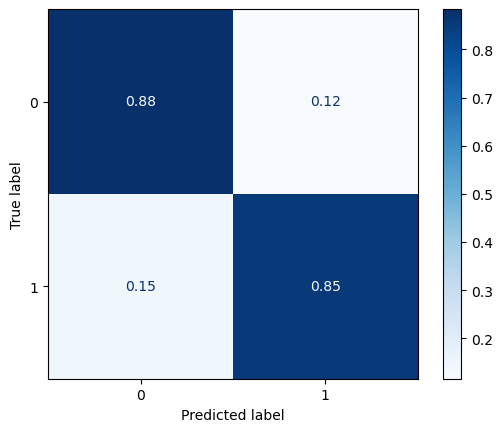

In [29]:
# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred = cross_val_predict(hgbc_model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

# Model: `HistGradientBoostingClassifier` - SMOTENC

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     11557
           1       0.86      0.83      0.85      8276

    accuracy                           0.87     19833
   macro avg       0.87      0.87      0.87     19833
weighted avg       0.87      0.87      0.87     19833



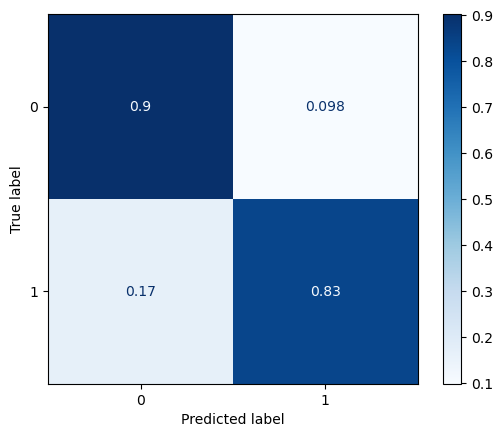

In [30]:
hgbc_model_smote = hgbc_model_pipeline[-1].fit(X_train_smote, y_train_smote)

y_pred = hgbc_model_smote.predict(X_test_transformed)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

# HGBC: SMOTE vs. Leaving Data Imbalanced

---

Based on the results of my models, the **F1 scores** are very similar, with only a 1% difference between them. However, the models show more significant differences in their **precision** and **recall** scores.

Given that the primary business objective is to **maximize revenue and occupancy**, prioritizing a higher **recall** is critical. Our goal is to correctly identify as many cancellations as possible, even if it means misclassifying some reservations that would have actualized. While this may introduce operational challenges—such as managing room inventory and the risk of overselling—both models perform reasonably well and are designed to help minimize **false negatives** (missed cancellations).

The best-performing model in terms of recall is the one trained on the imbalanced dataset, using the `class_weights = balanced` argument. I will now utilize the `SHAP` package to identify the most impactful features and propose actionable next steps for the hotel to proactively prevent cancellations.

---

# SHAP Results Review: HistGradientBoostingClassifier

### Non-SMOTE'ed Modeling Approach

In [37]:
## Use only if using model pipeline without SMOTENC
X_train_xf = hgbc_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_test_xf = hgbc_model_pipeline.named_steps.preprocessor.transform(X_test)

X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

explainer = shap.Explainer(hgbc_model_pipeline.named_steps.classifier, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test)

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -1.279978, while the model output was -0.672926. If this difference is acceptable you can set check_additivity=False to disable this check.

### SMOTE-Based Modeling Approach

In [33]:
# ## Use only if using SMOTENC data and associated model

# X_train_xf = X_train_smote
# X_test_xf = X_test_transformed

# X_shap_train = shap.sample(X_train_xf, 500)
# y_shap_train = y_train_smote.loc[X_shap_train.index]

# X_shap_test = shap.sample(X_test_xf, 500)
# y_shap_test = y_test.loc[X_shap_test.index]

# explainer = shap.Explainer(hgbc_model_smote, X_shap_train)
# shap_values_test = explainer(X_shap_test)

In [34]:
print(shap_values_test.shape)

(500, 181)


## Summary Plot

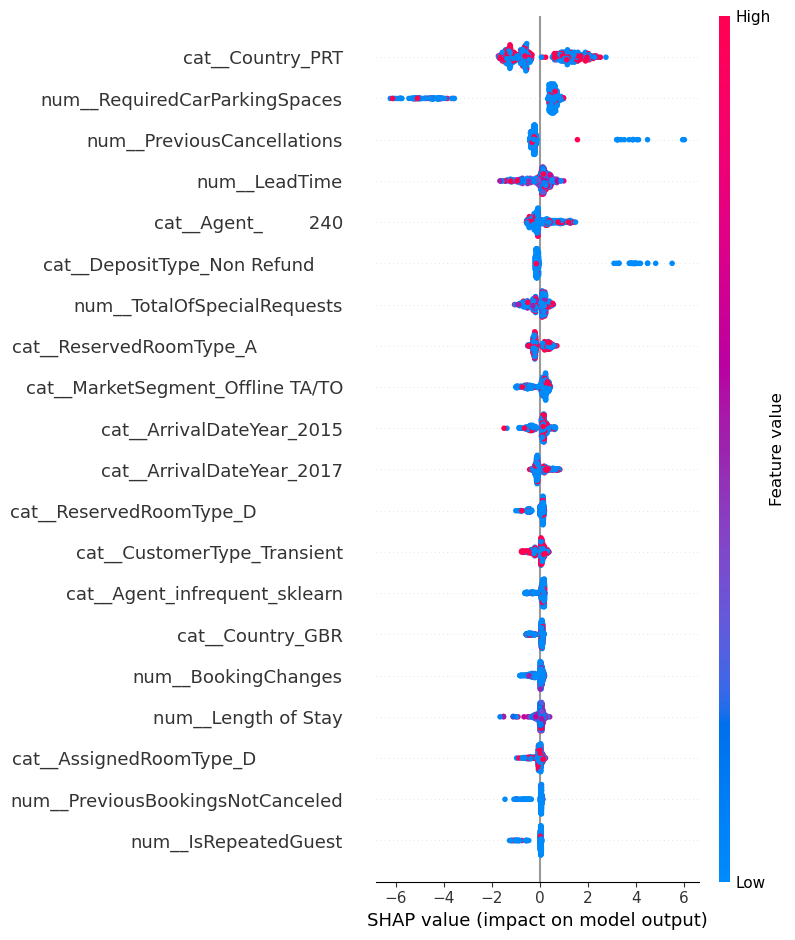

In [35]:
shap.summary_plot(shap_values_test, X_shap_train)

# Final Recommendations for Reducing Cancellations and Maximizing Occupancy

---

Based on the SHAP analysis of the HistGradientBoostingClassifier model, the following key actions are recommended to reduce cancellations and optimize revenue for the hotel:

1. *Prioritize High-Risk Guest Segments:*
   - **Portuguese guests** and **guests with a history of cancellations** should receive targeted engagement, including personalized offers, follow-up reminders, and flexible booking options.
   - Offer transportation incentives or perks to **non-parking guests** to increase commitment and reduce the likelihood of cancellations.

2. *Encourage Special Requests:*
   - Promote opportunities for guests to make **special requests** (e.g., room upgrades, dining preferences) during the booking process to increase engagement and reduce cancellations.

3. *Focus on Short Lead-Time Bookings:*
   - Provide **last-minute incentives** or **free cancellation deadlines** to encourage guests with short lead times to maintain their reservations.
   - For long lead-time bookings, maintain guest engagement with periodic offers to reduce cancellation risks over time.

4. *Leverage Automation and CRM Integration:*
   - Automate **personalized reminders, special offers, and engagement emails** based on guest behavior and risk profiles.
   - Integrate these predictive insights into the hotel's **CRM system** to build long-term guest loyalty and improve cancellation management.

5. *Monitor Key Metrics for Success:*
   - Track improvements in **cancellation rate**, **occupancy rate**, and **RevPAR** to evaluate the effectiveness of these strategies.
   - Regularly retrain and monitor the predictive model's performance to ensure continued accuracy in identifying high-risk guests.

By implementing these strategies, the hotel can significantly reduce cancellations, optimize room occupancy, and enhance overall guest satisfaction, all while balancing operational efficiency and revenue goals.

---

In [36]:
raise Exception('Appendices below - run manually!')

Exception: Appendices below - run manually!

# Appendices

## Testing - Using Only Numeric Features w/ SMOTETomek

In [ ]:
# Combine transformers into a single ColumnTransformer
preprocessor_num = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats)
])

In [ ]:
X_train_numeric = preprocessor_num.fit_transform(X_train)
X_test_numeric = preprocessor_num.transform(X_test)

In [ ]:
X_train_numeric

In [ ]:
## Set output settings to default arrays and apply SMOTETomek to balance the dataset
set_config(transform_output='default')

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_numeric, y_train)

In [ ]:
## Reset output settings to pandas and convert resampled data to DataFrames
set_config(transform_output='pandas')

X_train_num_STL = pd.DataFrame(X_resampled, columns=X_train_numeric.columns)
y_train_num_STL = pd.Series(y_resampled)

In [ ]:
# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_num_STL, y_train_num_STL)

In [ ]:
X_train_num_STL

In [ ]:
y_pred = rf_classifier.predict(X_test_numeric)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

## Permutation Importances

***SKIPPING - NOT USED IN FINAL EVALUATION***

In [ ]:
# # ## Using Pipeline Model to calculate permutation importances
# # result = permutation_importance(model_pipeline[-1],
# #                                 X_test, 
# #                                 y_test,
# #                                 n_jobs=-1)#,
# #                                 # scoring = 'f1')


# ## Using SMOTENC Model to calculate permutation importances
# result = permutation_importance(smotenc_model,
#                                 X_test_transformed, 
#                                 y_test,
#                                 n_jobs=-1)#,
#                                 # scoring = 'f1')


# # Extract importances and standard deviations
# perm_importances = result.importances_mean
# perm_importances_std = result.importances_std

# # Create a DataFrame for easy plotting
# importance_df = pd.DataFrame({
#     'Feature': X_test_transformed.columns,
#     'Importance': perm_importances,
#     'Importance_std': perm_importances_std
# }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# # Plot the feature importances
# sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);